In [1]:
import keras
from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape

Using TensorFlow backend.


In [13]:
# change your model here
model = load_model('BorderlineSMOTE2.h5')

In [3]:
import pickle

with open('BorderlineSMOTE_rgb.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')


data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)
data['y_test'] = to_categorical(data['y_test'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

x_train: (86430, 32, 32, 3)
y_train: (86430, 43)
x_validation: (4410, 32, 32, 3)
y_validation: (4410, 43)
x_test: (12630, 32, 32, 3)
y_test: (12630, 43)
labels: 43


In [4]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict(data['x_test'])
y_pred = np.argmax(Y_pred, axis=1)
y_val = np.argmax(data['y_test'],axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred))
print('Classification Report')
print(classification_report(y_val, y_pred))

Confusion Matrix
[[ 51   1   0 ...   0   0   0]
 [  1 697   2 ...   0   0   0]
 [  1  24 696 ...   0   0   1]
 ...
 [  0   0   0 ...  87   0   0]
 [  0   0   0 ...   0  56   0]
 [  0   0   0 ...   0   1  87]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        60
           1       0.95      0.97      0.96       720
           2       0.96      0.93      0.94       750
           3       0.92      0.89      0.90       450
           4       0.95      0.93      0.94       660
           5       0.78      0.93      0.84       630
           6       0.99      0.79      0.88       150
           7       0.96      0.79      0.87       450
           8       0.89      0.90      0.89       450
           9       0.96      0.99      0.97       480
          10       0.99      0.98      0.98       660
          11       0.86      0.93      0.89       420
          12       0.99      0.97      0.98       690
          13

In [5]:
test_accuracy = np.mean(y_pred == y_val)
print("test_accuracy: ", test_accuracy)

test_accuracy:  0.9351543942992874


In [9]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt

In [7]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(43):
    fpr[i], tpr[i], _ = roc_curve(data['y_test'][:,i], Y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(data['y_test'].ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

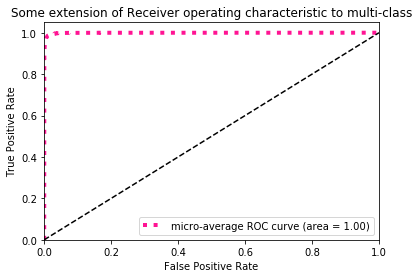

In [10]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(43)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(43):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 43

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

'''
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
'''
'''
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(43), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    '''

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [11]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(43):
    precision[i], recall[i], _ = precision_recall_curve(data['y_test'][:,i], Y_pred[:,i])
    average_precision[i] = average_precision_score(data['y_test'][:,i], Y_pred[:,i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(data['y_test'].ravel(),
    Y_pred.ravel())
average_precision["micro"] = average_precision_score(data['y_test'], Y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.98


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.98')

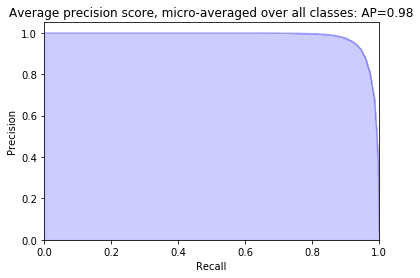

In [12]:
from inspect import signature
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})


plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))